# Display Physionet Recordings using Wavelets - ctg

see: https://physionet.org/physiobank/database/ctu-uhb-ctgdb/


Questions:
- Is this a useful way to remove noise
- Is this ia useful way to extract patterns

In [1]:
import config_local
from config_common import *

In [2]:
import wfdb
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

import pywt

In [3]:
from ctg_utils import get_all_recno, parse_meta_comments

In [4]:
from swt_filter import swt_align, replace_invalid_values, swt_process_signal

# Code

In [5]:
def filtUC(data, lowcut, fs=4, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = scipy.signal.butter(order, low, btype='lowpass')
    y = scipy.signal.filtfilt(b, a, data)
    return y

In [6]:
local_recordings_dir_full

'/Users/Test/Documents/GitHub/CTG_Analysis/local_data/sample_physionet_ctb_uhb_recordings'

In [7]:
!ls /Users/Test/Documents/GitHub/CTG_Analysis/local_data/sample_physionet_ctb_uhb_recordings

1001.dat 1001.hea 1002.dat 1002.hea


## Process Recordings


Record: 1001
nSamples: 19200
['----- Additional parameters for record 1001',
 '-- Outcome measures',
 'pH           7.14',
 'BDecf        8.14',
 'pCO2         7.7',
 'BE           -10.5',
 'Apgar1       6',
 'Apgar5       8',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  37',
 'Weight(g)    2660',
 'Sex          2',
 '-- Maternal (risk-)factors',
 'Age          32',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     1',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 1',
 'Pyrexia      0',
 'Meconium     0',
 '-- Delivery descriptors',
 'Presentation 2',
 'Induced      0',
 'I.stage      232',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     20',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         974204',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


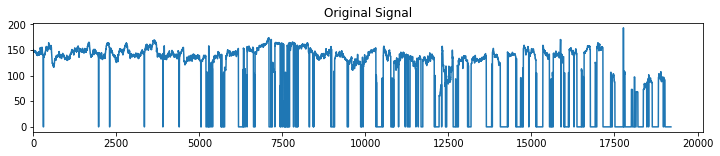

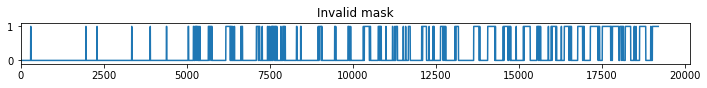

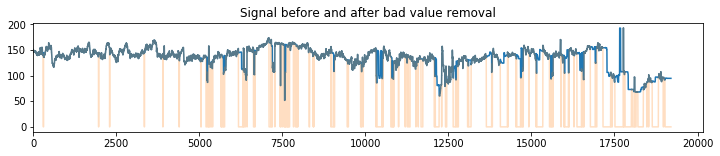

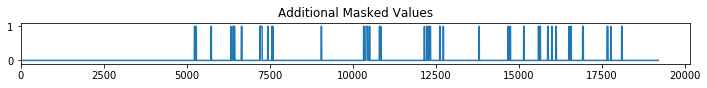

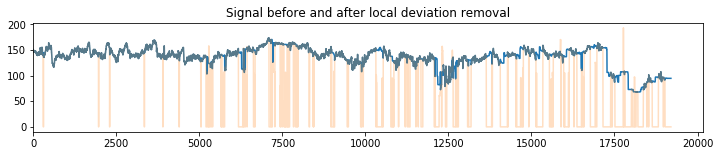

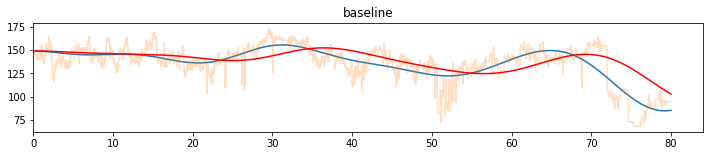

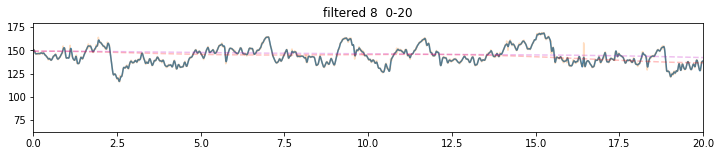

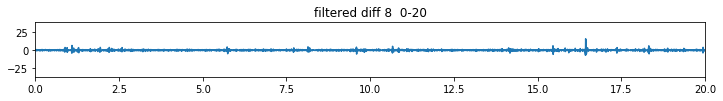

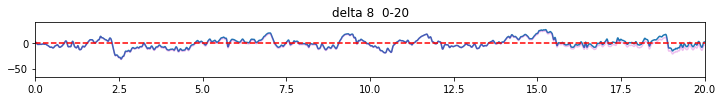

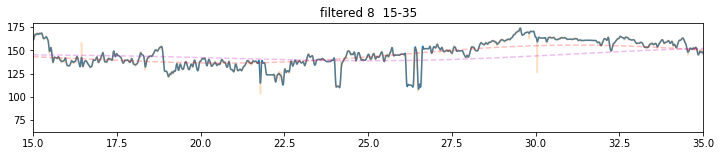

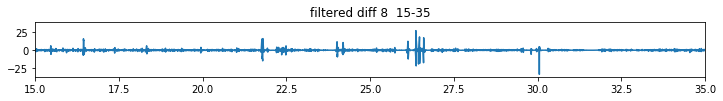

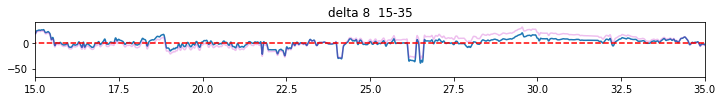

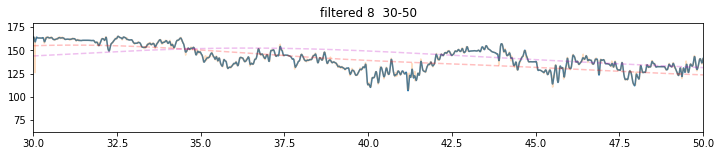

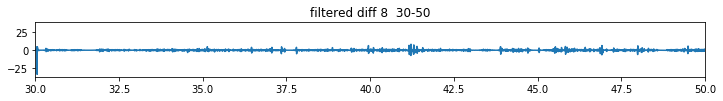

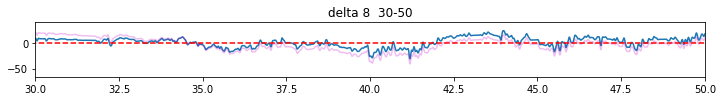

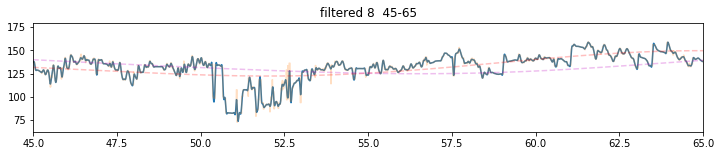

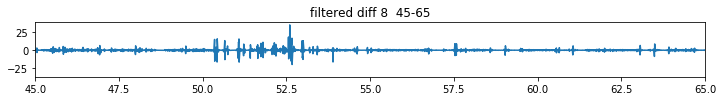

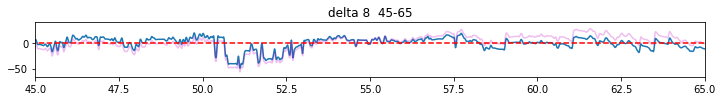

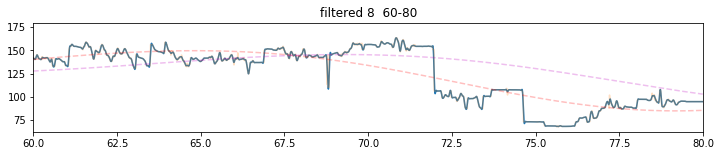

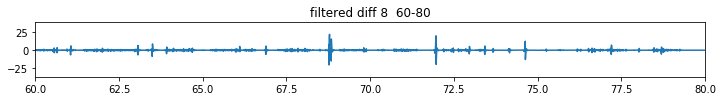

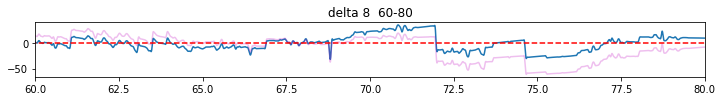


Record: 1002
nSamples: 19200
['----- Additional parameters for record 1002',
 '-- Outcome measures',
 'pH           7',
 'BDecf        7.92',
 'pCO2         12',
 'BE           -12',
 'Apgar1       8',
 'Apgar5       8',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  41',
 'Weight(g)    2900',
 'Sex          2',
 '-- Maternal (risk-)factors',
 'Age          23',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     0',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 0',
 'Pyrexia      0',
 'Meconium     1',
 '-- Delivery descriptors',
 'Presentation 1',
 'Induced      0',
 'I.stage      220',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     20',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         975666',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


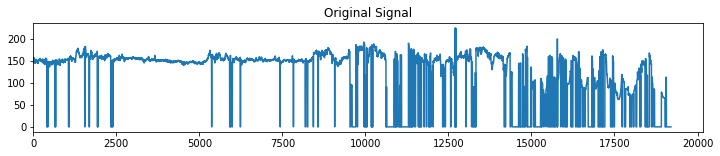

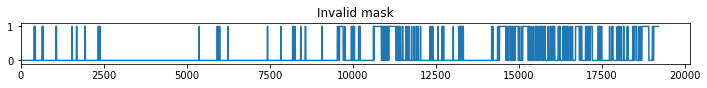

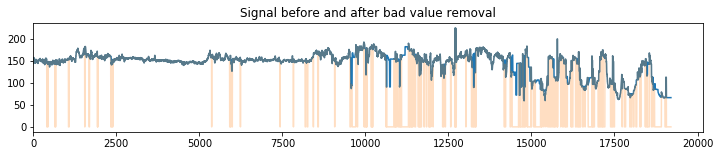

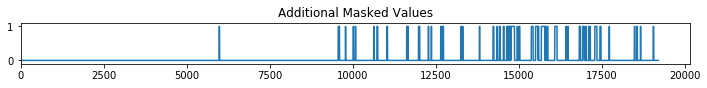

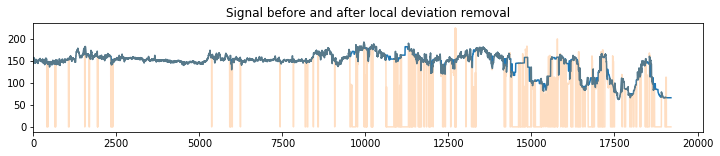

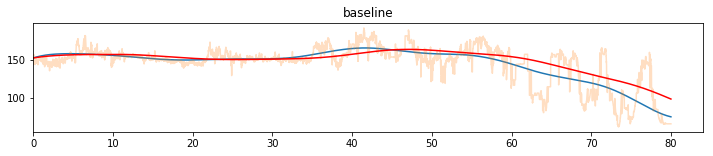

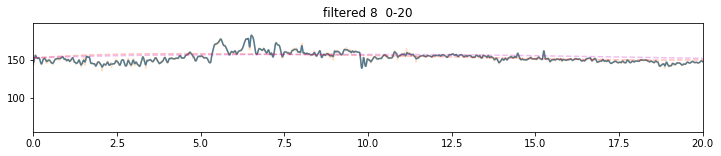

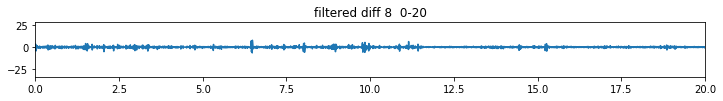

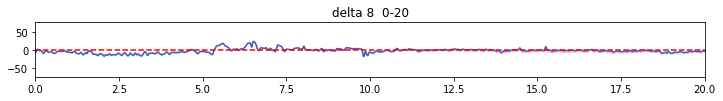

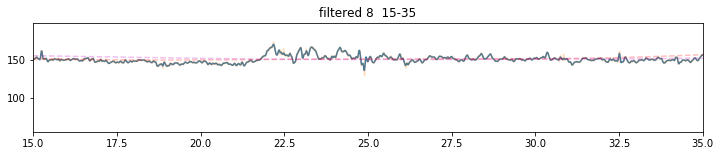

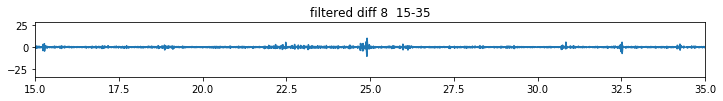

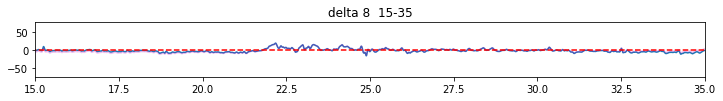

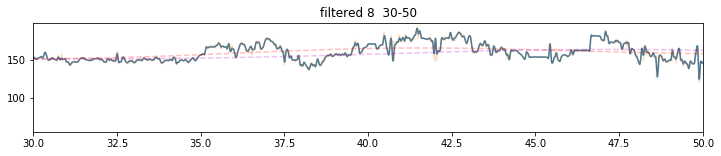

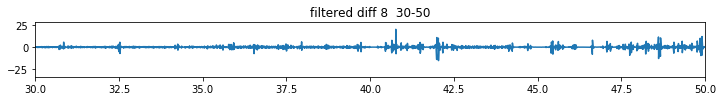

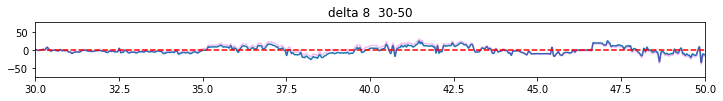

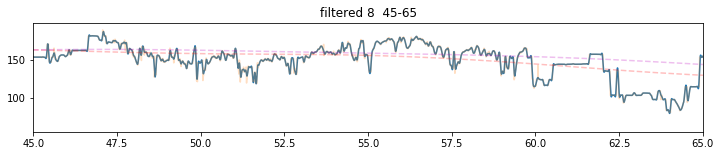

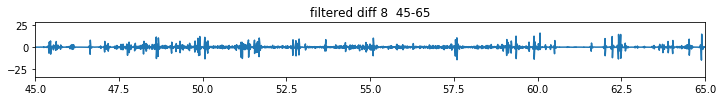

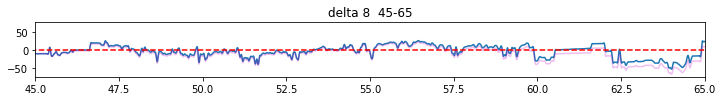

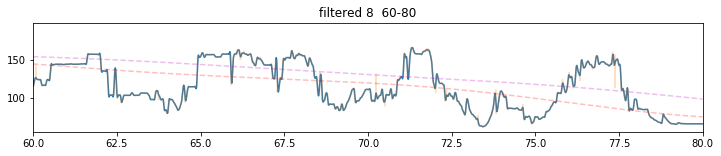

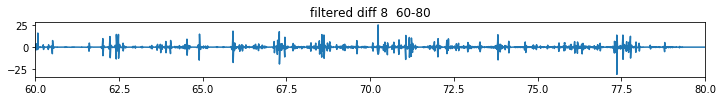

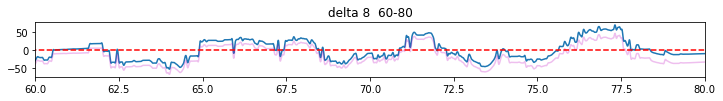

In [8]:
total_levels=11
exclude_level = 8
local_baseline_exclude_level=3
baseline_exclude_level=0

for recno in sorted(get_all_recno(local_recordings_dir_full)):
    recno_full = os.path.join(local_recordings_dir_full, recno)
    print('\nRecord: {}'.format(recno))
    all_sig, meta = wfdb.io.rdsamp(recno_full)
    print('nSamples: {}'.format(all_sig.shape[0]))
    pprint(meta['comments'])
    
    orig_hr = all_sig[:, 0]
    sig_uc = all_sig[:, 1]
    
    masked_hr = np.copy(orig_hr)
    masked_hr[masked_hr < 10] = 0
    masked_hr[masked_hr >= 240] = 0
    
    sig_hr = replace_invalid_values(masked_hr, window=60*4)
    
    plt.figure(figsize=(12, 2))
    plt.title('Original Signal')
    plt.plot(orig_hr)
    plt.xlim(0,)
    plt.show() 
    
    
    mask = masked_hr == 0
    plt.figure(figsize=(12, 0.75))
    plt.title('Invalid mask')
    plt.plot(mask)
    plt.xlim(0,)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    plt.figure(figsize=(12, 2))
    plt.title('Signal before and after bad value removal')
    plt.plot(sig_hr)
    plt.plot(orig_hr, alpha=0.25)
    plt.xlim(0,)
    plt.show() 
    
    #
    # ignore regions with large deviations
    #
    _, local_baseline, ts = swt_process_signal(sig_hr, exclude_level=local_baseline_exclude_level, 
                                                      total_levels=total_levels, fs=meta['fs'])
    
    
    mask = np.abs(sig_hr-local_baseline) > 25
    masked_hr[mask] = 0

    sig_hr = replace_invalid_values(masked_hr, window=60*4)
    #sig_hr = replace_invalid_values(masked_hr, use_interpolate=True)
    
    plt.figure(figsize=(12, 0.75))
    plt.title('Additional Masked Values')
    plt.plot(mask)
    plt.xlim(0,)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    plt.figure(figsize=(12, 2))
    plt.title('Signal before and after local deviation removal')
    plt.plot(sig_hr)
    plt.plot(orig_hr, alpha=0.25)
    plt.xlim(0,)
    plt.show()

    baseline, sig_f, ts = swt_process_signal(sig_hr, exclude_level=exclude_level, 
                                                    baseline_exclude_level=baseline_exclude_level,
                                                    total_levels=total_levels, fs=meta['fs'])

    baseline2 = np.array([np.mean(baseline[max(0, i-10*60*4):i+1]) for i in range(len(baseline))])
    
    delta = sig_f - baseline
    delta2 = sig_f - baseline2
    tm = ts/60.0

    plt.figure(figsize=(12, 2))
    plt.title('baseline')
    plt.plot(tm, baseline)
    plt.plot(tm, sig_hr, alpha=0.25)
    plt.plot(tm, baseline2, 'r')
    plt.xlim(0,)
    plt.show()  


    t_wid=20
    t_offset = 15
    for tStart in range(0, int(tm[-1])-t_offset, t_offset):
        plt.figure(figsize=(12, 2))
        plt.title('filtered {}  {}-{}'.format(exclude_level, tStart,tStart+t_wid))
        plt.plot(tm, sig_f)
        plt.plot(tm, sig_hr, alpha=0.25)
        plt.plot(tm, baseline, 'r--', alpha=0.25)
        plt.plot(tm, baseline2, 'm--', alpha=0.25)
        plt.xlim(tStart,tStart+t_wid)
        plt.show()

        plt.figure(figsize=(12, 1))
        plt.title('filtered diff {}  {}-{}'.format(exclude_level, tStart,tStart+t_wid))
        plt.plot(tm, sig_hr- sig_f)
        plt.xlim(tStart,tStart+t_wid)
        plt.show()

        plt.figure(figsize=(12, 1))
        plt.title('delta {}  {}-{}'.format(exclude_level, tStart,tStart+t_wid))
        plt.plot(tm, delta)
        plt.plot(tm, delta2, 'm', alpha=0.25)
        #plt.plot(tm, sig_hr-baseline, alpha=0.25)
        #plt.plot(tm, sig_hr-baseline2, 'm', alpha=0.25)
        plt.plot([tm[0], tm[-1]], [0,0], 'r--')
        plt.xlim(tStart,tStart+t_wid)
        plt.show()

